# Generate 2D Data

Notebook to generate 2D data for active learning paper

In [3]:
import numpy as np
import dask.array as da

from pymks import (
    generate_multiphase,
    plot_microstructures,
    solve_fe
)

## Generate Data Functions

Functions to generate the microstructure. The microstructures are stochastically generated from 6 nominal classes.

In [15]:
#def shuffle(data):
#    tmp = np.array(data)
#    np.random.shuffle(tmp)
#    return da.from_array(tmp, chunks=data.chunks)

#def generate_x(shape, seed):
#    da.random.seed(seed)
#    np.random.seed(seed)

#    tmp = [
#        generate_multiphase(shape=shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=50, percent_variance=0.05)
#        for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
#    ]
#    return np.array(shuffle(da.concatenate(tmp)))


def shuffle(data, chunk_size):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=(chunk_size,) + tmp.shape[1:])

def generate_x(shape, n_sample, seed, max_size=20, chunk_size=100):
    da.random.seed(seed)
    np.random.seed(seed)#

    tmp = [
        generate_multiphase(shape=(1,) + shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=1, percent_variance=0.3)
        for x in np.random.randint(2, 20, size=(n_sample, 2))
    ]
    
    return np.array(shuffle(da.concatenate(tmp), chunk_size))


def oracle_from_data(x_data):
    y_stress = solve_fe(x_data,
#                        elastic_modulus=(1.3, 2.5),
                        elastic_modulus=(120.0, 2.4),
                        poissons_ratio=(0.3, 0.3),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

## Generate the data

In [26]:
x_data = generate_x((51, 51), 500, 99, chunk_size=50)
print(x_data.shape)

(500, 51, 51)


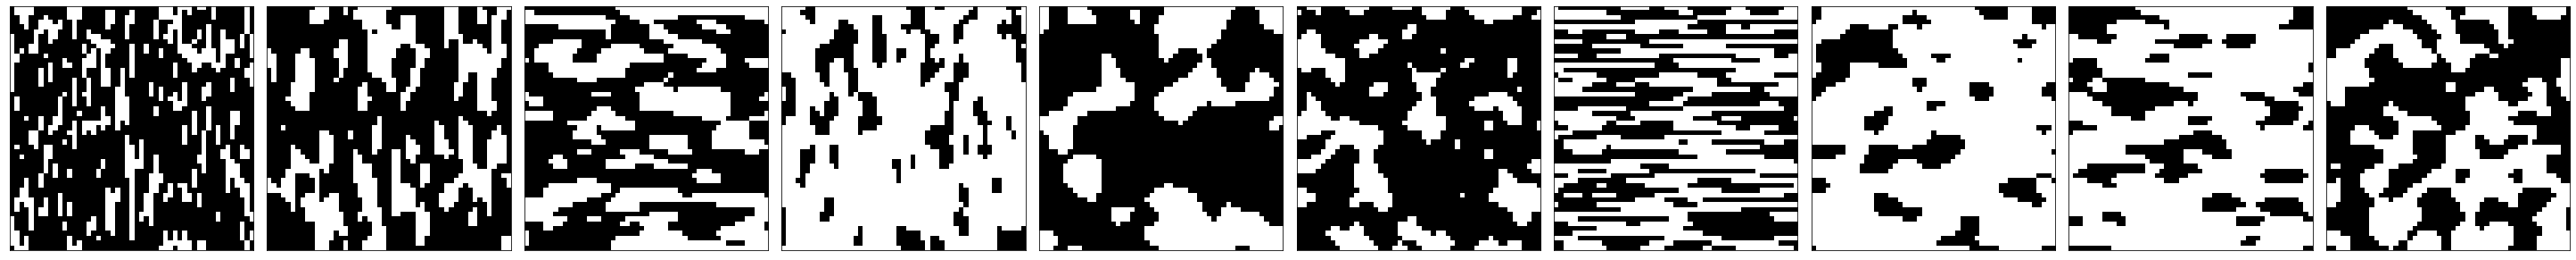

In [27]:
plot_microstructures(*x_data[10:20], cmap='gray', colorbar=False);

In [28]:
import time
print(time.strftime('%l:%M%p %z on %b %d, %Y'))
y_data = oracle_from_data(x_data)
print(time.strftime('%l:%M%p %z on %b %d, %Y'))

 1:17PM -0500 on Jan 19, 2023
 1:30PM -0500 on Jan 19, 2023


In [29]:
print(x_data.shape)
print(y_data.shape)

(500, 51, 51)
(500,)


2.5 minutes for 10 samples
28.2 minutes for 100 samples
20 hours for 1000 samples
about 5 hours for 1000 samples

In [30]:
np.savez_compressed('data-500-51-51.npz', x_data=np.array(x_data), y_data=np.array(y_data))